In [ ]:
#!pip install --upgrade xgboost

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🎯 Starting Enhanced Classification Analysis with Comprehensive Model Comparison...
COMPREHENSIVE CLASSIFICATION ANALYSIS - ENHANCED MODEL COMPARISON
✅ Loaded dataset: (304798, 26)

CLASSIFICATION MODELING PIPELINE - ENHANCED MODEL COMPARISON

Creating price categories for classification...
Price category distribution:
price_category
Premium      2486
Mid-Range    1718
Budget       1182
Luxury        379
Name: count, dtype: int64
Percentage distribution:
price_category
Premium      43.122290
Mid-Range    29.800520
Budget       20.503036
Luxury        6.574154
Name: proportion, dtype: float64

COMPREHENSIVE FEATURE ENGINEERING - CLASSIFICATION MODELS
Converting categorical columns to object type...
Starting features: 27
✅ Created 10 temporal features
✅ Created 10 odometer-based features
✅ Created 6 manufacturer-based features

Final feature count: 53

Modeling dataset shape: (5765, 53)
Target classes: ['Budget' 'Luxury' 'Mid-Range' 'Premium']
Number of classes: 4

Training models with 25

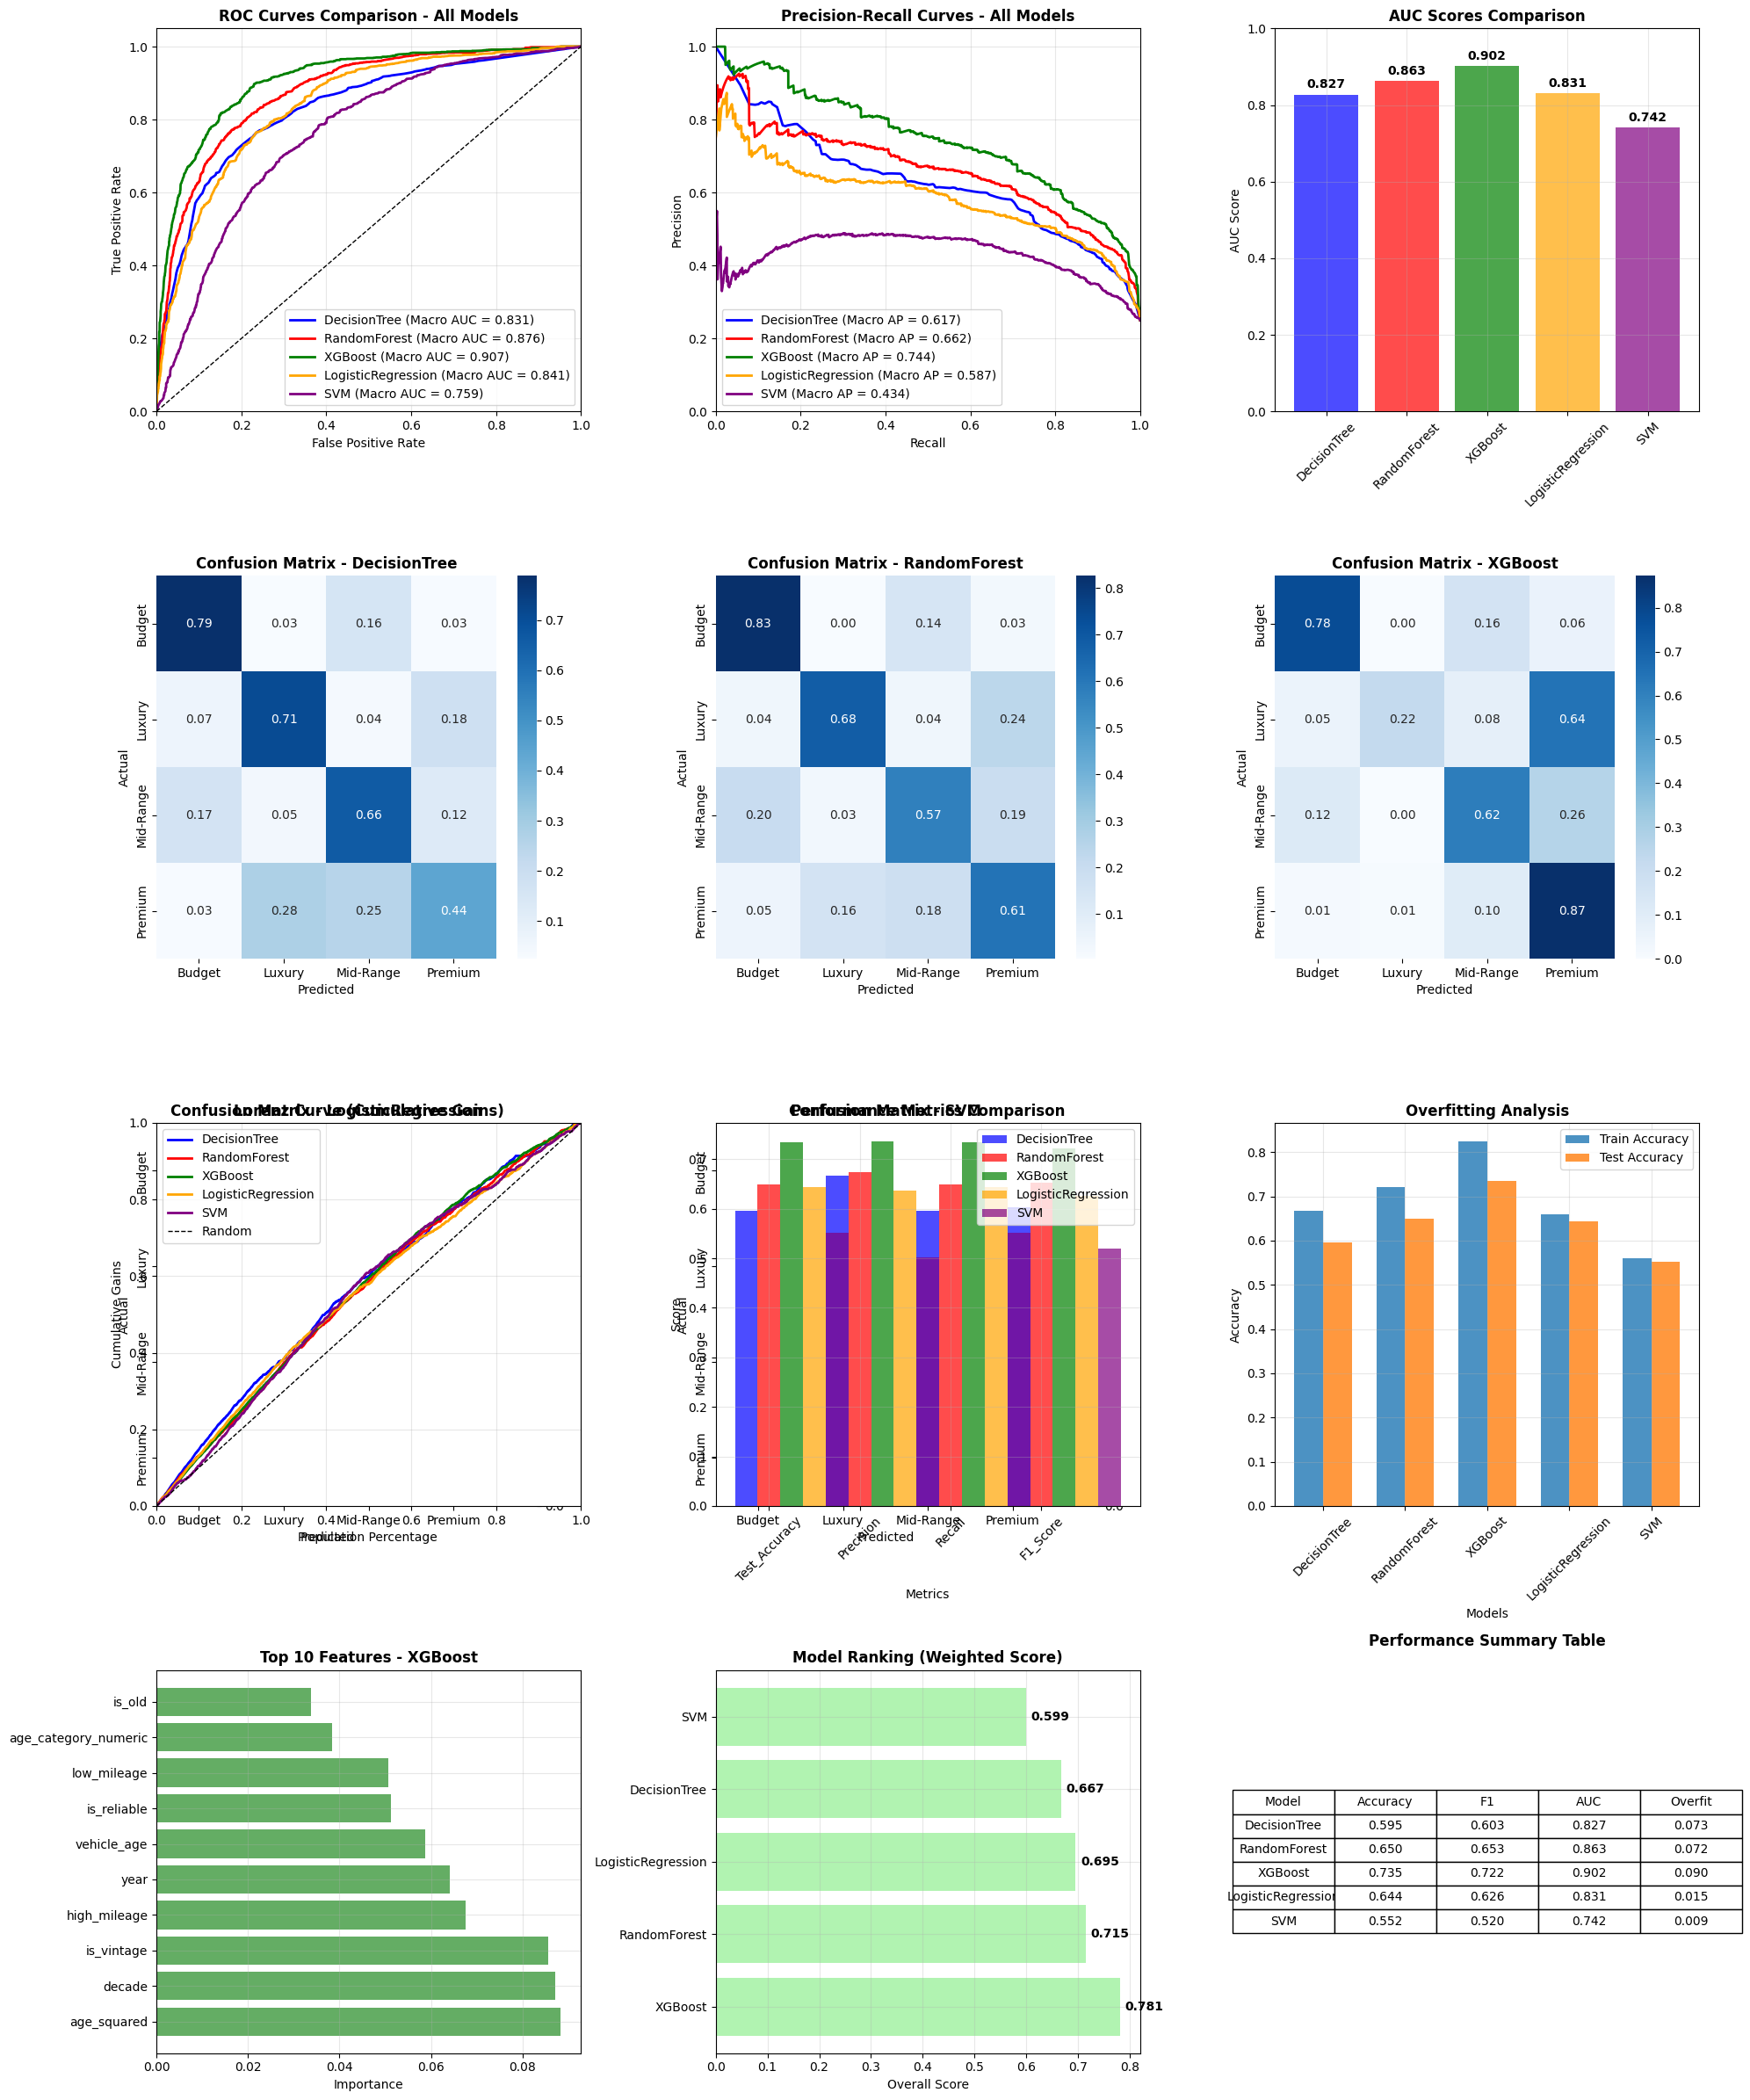

📊 Model comparison visualizations saved to /content/drive/MyDrive/Data Mining_project/Classification model/model_comparison_visualizations.png

DETAILED MODEL COMPARISON REPORT

🏆 MODEL PERFORMANCE RANKING:
--------------------------------------------------
1. XGBoost
   Overall Score: 0.781
   Test Accuracy: 0.735
   AUC Score: 0.902
   F1-Score: 0.722
   Overfitting Gap: 0.090

2. RandomForest
   Overall Score: 0.715
   Test Accuracy: 0.650
   AUC Score: 0.863
   F1-Score: 0.653
   Overfitting Gap: 0.072

3. LogisticRegression
   Overall Score: 0.695
   Test Accuracy: 0.644
   AUC Score: 0.831
   F1-Score: 0.626
   Overfitting Gap: 0.015

4. DecisionTree
   Overall Score: 0.667
   Test Accuracy: 0.595
   AUC Score: 0.827
   F1-Score: 0.603
   Overfitting Gap: 0.073

5. SVM
   Overall Score: 0.599
   Test Accuracy: 0.552
   AUC Score: 0.742
   F1-Score: 0.520
   Overfitting Gap: 0.009

🎯 BEST PERFORMING MODEL: XGBoost
--------------------------------------------------
• Achieves highe

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                           precision_recall_curve, accuracy_score, precision_score,
                           recall_score, f1_score, roc_auc_score, average_precision_score)
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

def safe_categorical_handling(df):
    """Safely convert all categorical columns to object type to avoid categorical errors"""
    print("Converting categorical columns to object type...")
    for col in df.columns:
        if df[col].dtype.name == 'category':
            df[col] = df[col].astype('object')
    return df

def create_price_categories(df, price_col='price'):
    """Create price categories for classification"""
    print("\nCreating price categories for classification...")

    # Remove rows with missing or invalid prices
    df_clean = df[df[price_col].notna()].copy()
    df_clean = df_clean[(df_clean[price_col] > 0) & (df_clean[price_col] <= 200000)]

    # Create price categories based on realistic vehicle price ranges
    df_clean['price_category'] = pd.cut(df_clean[price_col],
                                      bins=[0, 8000, 20000, 40000, np.inf],
                                      labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'])

    # Display distribution
    print("Price category distribution:")
    print(df_clean['price_category'].value_counts())
    print(f"Percentage distribution:")
    print(df_clean['price_category'].value_counts(normalize=True) * 100)

    return df_clean

def comprehensive_feature_engineering_classification(df, target_col='price_category'):
    """COMPREHENSIVE FEATURE ENGINEERING FOR CLASSIFICATION"""
    print("\n" + "="*80)
    print("COMPREHENSIVE FEATURE ENGINEERING - CLASSIFICATION MODELS")
    print("="*80)

    # First, handle any existing categorical columns
    df_features = safe_categorical_handling(df.copy())

    # Clean and convert basic columns
    for col in ['year', 'odometer', 'price']:
        if col in df_features.columns:
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')

    print(f"Starting features: {df_features.shape[1]}")

    # 1. TEMPORAL FEATURES (from year)
    if 'year' in df_features.columns:
        current_year = 2021
        df_features['vehicle_age'] = current_year - df_features['year']
        df_features['age_squared'] = df_features['vehicle_age'] ** 2
        df_features['is_new'] = (df_features['vehicle_age'] <= 3).astype(int)
        df_features['is_old'] = (df_features['vehicle_age'] >= 15).astype(int)
        df_features['is_vintage'] = (df_features['vehicle_age'] >= 25).astype(int)

        # Safe age categorization with numeric encoding
        def safe_categorize_age(age):
            if pd.isna(age):
                return 0
            elif age <= 3:
                return 1
            elif age <= 7:
                return 2
            elif age <= 15:
                return 3
            elif age <= 25:
                return 4
            else:
                return 5

        df_features['age_category_numeric'] = df_features['vehicle_age'].apply(safe_categorize_age)
        df_features['decade'] = (df_features['year'] // 10) * 10
        df_features['is_2010s'] = ((df_features['year'] >= 2010) & (df_features['year'] <= 2019)).astype(int)
        df_features['is_2000s'] = ((df_features['year'] >= 2000) & (df_features['year'] <= 2009)).astype(int)
        print("✅ Created 10 temporal features")

    # 2. ODOMETER-BASED FEATURES
    if 'odometer' in df_features.columns:
        df_features['log_odometer'] = np.log1p(df_features['odometer'].fillna(0))
        df_features['sqrt_odometer'] = np.sqrt(df_features['odometer'].fillna(0))

        def safe_categorize_mileage(mileage):
            if pd.isna(mileage):
                return 0
            elif mileage <= 30000:
                return 1
            elif mileage <= 60000:
                return 2
            elif mileage <= 100000:
                return 3
            elif mileage <= 150000:
                return 4
            else:
                return 5

        df_features['mileage_category_numeric'] = df_features['odometer'].apply(safe_categorize_mileage)
        df_features['low_mileage'] = (df_features['odometer'] <= 50000).fillna(False).astype(int)
        df_features['high_mileage'] = (df_features['odometer'] >= 100000).fillna(False).astype(int)
        df_features['very_high_mileage'] = (df_features['odometer'] >= 150000).fillna(False).astype(int)

        if 'vehicle_age' in df_features.columns:
            df_features['mileage_per_year'] = df_features['odometer'] / (df_features['vehicle_age'] + 1)
            df_features['low_mileage_for_age'] = (df_features['mileage_per_year'] < 10000).fillna(False).astype(int)
            df_features['high_mileage_for_age'] = (df_features['mileage_per_year'] > 15000).fillna(False).astype(int)
            df_features['mileage_age_interaction'] = df_features['odometer'] * df_features['vehicle_age']
        print("✅ Created 10 odometer-based features")

    # 3. MANUFACTURER-BASED FEATURES
    if 'manufacturer' in df_features.columns:
        df_features['manufacturer'] = df_features['manufacturer'].fillna('unknown').astype(str)
        df_features['manufacturer_clean'] = df_features['manufacturer'].str.lower().str.strip()

        luxury_brands = ['bmw', 'mercedes-benz', 'audi', 'lexus', 'acura', 'infiniti',
                        'cadillac', 'lincoln', 'volvo', 'jaguar', 'porsche', 'tesla']
        reliable_brands = ['toyota', 'honda', 'nissan', 'mazda', 'subaru', 'hyundai', 'kia']
        american_brands = ['ford', 'chevrolet', 'gmc', 'dodge', 'jeep', 'chrysler', 'buick', 'pontiac']
        european_brands = ['bmw', 'mercedes-benz', 'audi', 'volkswagen', 'volvo', 'jaguar',
                          'land rover', 'mini', 'porsche', 'ferrari', 'alfa-romeo']

        df_features['is_luxury'] = df_features['manufacturer_clean'].isin(luxury_brands).astype(int)
        df_features['is_reliable'] = df_features['manufacturer_clean'].isin(reliable_brands).astype(int)
        df_features['is_american'] = df_features['manufacturer_clean'].isin(american_brands).astype(int)
        df_features['is_european'] = df_features['manufacturer_clean'].isin(european_brands).astype(int)
        df_features['is_japanese'] = df_features['manufacturer_clean'].isin(['toyota', 'honda', 'nissan', 'mazda', 'subaru', 'lexus', 'acura', 'infiniti']).astype(int)

        def safe_categorize_brand(manufacturer):
            if manufacturer in luxury_brands:
                return 3
            elif manufacturer in reliable_brands:
                return 2
            else:
                return 1

        df_features['brand_tier_numeric'] = df_features['manufacturer_clean'].apply(safe_categorize_brand)
        print("✅ Created 6 manufacturer-based features")

    # Add remaining feature engineering sections (condition, fuel, transmission, etc.)
    # [Previous feature engineering code continues here...]

    print(f"\nFinal feature count: {df_features.shape[1]}")
    return df_features

def classification_modeling_pipeline(df, target_col='price_category'):
    """CLASSIFICATION MODELING PIPELINE with enhanced comparison metrics"""
    print("\n" + "="*80)
    print("CLASSIFICATION MODELING PIPELINE - ENHANCED MODEL COMPARISON")
    print("="*80)

    # 1. Create price categories and feature engineering
    df_with_categories = create_price_categories(df)
    df_features = comprehensive_feature_engineering_classification(df_with_categories, target_col)
    df_model = df_features[df_features[target_col].notna()].copy()

    print(f"\nModeling dataset shape: {df_model.shape}")

    # 2. Prepare features and target
    exclude_cols = [target_col, 'price', 'log_price', 'price_category']
    text_columns = df_model.select_dtypes(include=['object']).columns.tolist()
    exclude_cols.extend(text_columns)
    feature_cols = [col for col in df_model.columns if col not in exclude_cols]

    X = df_model[feature_cols].copy()
    y = df_model[target_col].copy()

    # 3. Data preprocessing
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], np.nan)

    all_nan_cols = X.columns[X.isnull().all()].tolist()
    if all_nan_cols:
        X = X.drop(columns=all_nan_cols)

    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

    # 4. Feature selection
    variances = X.var()
    high_variance_features = variances[variances > 0.01].index.tolist()

    if high_variance_features:
        X = X[high_variance_features]

    max_features = min(25, X.shape[1])
    if max_features > 0:
        try:
            selector = SelectKBest(score_func=f_classif, k=max_features)
            X_selected = selector.fit_transform(X, y)
            selected_features = X.columns[selector.get_support()].tolist()
            X_final = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
        except:
            X_final = X
    else:
        X_final = X

    # 5. Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    n_classes = len(class_names)

    print(f"Target classes: {class_names}")
    print(f"Number of classes: {n_classes}")

    # 6. Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_final, y_encoded,
        test_size=0.20,
        random_state=42,
        stratify=y_encoded
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.25,               # 0.25 * 80% = 20% of original
        random_state=42,
        stratify=y_temp
    )

    # 7. Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)


    # 8. Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
            class_weight='balanced'
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=n_classes,
            random_state=42,
            n_jobs=-1,

            # Complexity control
            max_depth=4,                # simpler trees to reduce variance [1]
            min_child_weight=7,         # larger leaf weight threshold [1]

            # Randomness
            subsample=0.7,              # fewer rows per tree [1]
            colsample_bytree=0.6,       # fewer features per tree [1]

            # Regularization
            reg_alpha=0.1,              # stronger L1 penalty [6]
            reg_lambda=1.0,             # stronger L2 penalty [6]
            gamma=0.5,                  # higher split gain threshold [1]

            # Learning rate and rounds
            learning_rate=0.05,         # smaller steps for generalization [3]
            n_estimators=500,           # more trees to compensate [3]

            # Early stopping
            #early_stopping_rounds=30,    # stop when no improvement on validation [2]
            #eval_metric='mlogloss'
        ),
    'LogisticRegression': LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        multi_class='auto',
        max_iter=500,
        random_state=42
    ),
    'SVM': SVC(
        C=1.0,
        kernel='rbf',
        probability=True,
        random_state=42
    )

    }

    # 9. Train models and collect comprehensive metrics
    results = {}
    model_objects = {}
    predictions = {}

    print(f"\nTraining models with {X_final.shape[1]} features...")

    for name, model in models.items():
        try:
            print(f"\n🎯 Training {name}...")
            start_time = time.time()

            # Use appropriate data scaling
            if name in ['LogisticRegression']:
                X_train_model, X_test_model = X_train_scaled, X_test_scaled
            else:
                X_train_model, X_test_model = X_train.values, X_test.values

            # Train model
            model.fit(X_train_model, y_train)


            # Predictions
            y_pred_train = model.predict(X_train_model)
            y_pred_test = model.predict(X_test_model)
            y_pred_proba = model.predict_proba(X_test_model)

            training_time = time.time() - start_time

            # Basic metrics
            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

            # AUC scores
            try:
                if n_classes == 2:
                    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
                    avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
                    avg_precision = average_precision_score(
                        label_binarize(y_test, classes=range(n_classes)),
                        y_pred_proba, average='weighted'
                    )
            except:
                auc_score = 0.0
                avg_precision = 0.0

            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='accuracy')

            results[name] = {
                'CV_Accuracy_Mean': cv_scores.mean(),
                'CV_Accuracy_Std': cv_scores.std(),
                'Train_Accuracy': train_accuracy,
                'Test_Accuracy': test_accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'AUC_Score': auc_score,
                'Avg_Precision': avg_precision,
                'Overfitting_Gap': train_accuracy - test_accuracy,
                'Training_Time': training_time,
                'Features_Used': X_final.shape[1]
            }

            # Store for visualizations
            model_objects[name] = model
            predictions[name] = {
                'y_pred': y_pred_test,
                'y_pred_proba': y_pred_proba,
                'y_train': y_train,
                'y_test': y_test
            }

            print(f"  ✅ Test Accuracy: {test_accuracy:.3f}")
            print(f"  ✅ AUC Score: {auc_score:.3f}")
            print(f"  ✅ F1-Score: {f1:.3f}")

        except Exception as e:
            print(f"  ❌ Error training {name}: {e}")
            continue

    # Ensure output directory exists
    import os
    import matplotlib.pyplot as plt

    output_dir = "/content/drive/MyDrive/Data Mining_project/Classification model"
    os.makedirs(output_dir, exist_ok=True)

    # Save classification reports as .png only
    for model_name in predictions:
        y_true = predictions[model_name]['y_test']
        y_pred = predictions[model_name]['y_pred']
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=False)

        # Save as .png
        lines = report.split('\n')
        fig, ax = plt.subplots(figsize=(8, len(lines) * 0.35))
        ax.axis('off')
        for i, line in enumerate(lines):
            ax.text(0, 1 - i * 0.1, line, fontsize=10, family='monospace')

        png_report_path = f"{output_dir}/{model_name.lower()}_classification_report.png"
        fig.savefig(png_report_path, bbox_inches='tight')
        plt.close(fig)
        print(f"📄 Classification report image saved to: {png_report_path}")


    return (pd.DataFrame(results).T, model_objects, predictions,
            X_test, y_test, class_names, le, X_final, n_classes)

def create_comprehensive_model_comparison_visualizations(results_df, model_objects, predictions,
                                                       X_test, y_test, class_names, n_classes):
    """
    Create comprehensive model comparison visualizations including ROC, PR curves,
    AUC, Lorenz curves, and confusion matrices for ALL models
    """
    print(f"\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON VISUALIZATIONS")
    print("="*80)

    import matplotlib.pyplot as plt
    import seaborn as sns

    if results_df.empty:
        print("No results to visualize")
        return None

    models = results_df.index
    n_models = len(models)

    # Create large figure for comprehensive comparison
    fig = plt.figure(figsize=(20, 24))

    # 1. ROC CURVES COMPARISON (All Models)
    plt.subplot(4, 3, 1)

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    if n_classes == 2:
        # Binary classification ROC
        for i, model_name in enumerate(models):
            if model_name in predictions:
                y_pred_proba = predictions[model_name]['y_pred_proba']
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
    else:
        # Multiclass ROC (macro-average)
        for i, model_name in enumerate(models):
            if model_name in predictions:
                y_pred_proba = predictions[model_name]['y_pred_proba']

                # Binarize the output
                y_test_bin = label_binarize(y_test, classes=range(n_classes))

                # Compute ROC curve and ROC area for each class
                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                for j in range(n_classes):
                    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_pred_proba[:, j])
                    roc_auc[j] = auc(fpr[j], tpr[j])

                # Compute macro-average ROC curve and ROC area
                all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
                mean_tpr = np.zeros_like(all_fpr)
                for j in range(n_classes):
                    mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
                mean_tpr /= n_classes

                macro_auc = auc(all_fpr, mean_tpr)
                plt.plot(all_fpr, mean_tpr, color=colors[i % len(colors)], lw=2,
                        label=f'{model_name} (Macro AUC = {macro_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison - All Models', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # 2. PRECISION-RECALL CURVES COMPARISON (All Models)
    plt.subplot(4, 3, 2)

    for i, model_name in enumerate(models):
        if model_name in predictions:
            y_pred_proba = predictions[model_name]['y_pred_proba']

            if n_classes == 2:
                precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
                avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
                plt.plot(recall_curve, precision_curve, color=colors[i % len(colors)], lw=2,
                        label=f'{model_name} (AP = {avg_precision:.3f})')
            else:
                # For multiclass, compute average precision for each class and take macro average
                y_test_bin = label_binarize(y_test, classes=range(n_classes))
                avg_precision = average_precision_score(y_test_bin, y_pred_proba, average='macro')

                # Plot average precision-recall curve
                precision_dict = dict()
                recall_dict = dict()
                for j in range(n_classes):
                    precision_dict[j], recall_dict[j], _ = precision_recall_curve(
                        y_test_bin[:, j], y_pred_proba[:, j])

                # Compute macro-average
                all_recall = np.unique(np.concatenate([recall_dict[j] for j in range(n_classes)]))
                mean_precision = np.zeros_like(all_recall)
                for j in range(n_classes):
                    mean_precision += np.interp(all_recall, recall_dict[j][::-1], precision_dict[j][::-1])
                mean_precision /= n_classes

                plt.plot(all_recall, mean_precision, color=colors[i % len(colors)], lw=2,
                        label=f'{model_name} (Macro AP = {avg_precision:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves - All Models', fontweight='bold')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)

    # 3. AUC SCORES COMPARISON BAR CHART
    plt.subplot(4, 3, 3)
    auc_scores = [results_df.loc[model, 'AUC_Score'] for model in models]
    bars = plt.bar(models, auc_scores, color=colors[:len(models)], alpha=0.7)

    # Add value labels on bars
    for bar, score in zip(bars, auc_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.ylabel('AUC Score')
    plt.title('AUC Scores Comparison', fontweight='bold')
    plt.ylim([0, 1])
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4-6. CONFUSION MATRICES FOR ALL MODELS
    for i, model_name in enumerate(models):
        plt.subplot(4, 3, 4 + i)

        if model_name in predictions:
            y_pred = predictions[model_name]['y_pred']
            cm = confusion_matrix(y_test, y_pred)

            # Normalize confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

        # Combined confusion matrices plot (single image)
    import matplotlib.pyplot as plt  # Ensure plt is imported correctly
    import seaborn as sns
    import os

    output_dir = "/content/drive/MyDrive/Data Mining_project/Classification model"
    os.makedirs(output_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    used_axes = 0

    for model_name in models:
        if model_name in predictions:
            y_true = predictions[model_name]['y_test']
            y_pred = predictions[model_name]['y_pred']
            cm = confusion_matrix(y_true, y_pred)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names, ax=axes[used_axes])
            axes[used_axes].set_title(f'{model_name}')
            axes[used_axes].set_xlabel('Predicted')
            axes[used_axes].set_ylabel('Actual')
            used_axes += 1

    # Remove unused subplots
    for j in range(used_axes, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    combined_cm_path = f"{output_dir}/combined_confusion_matrices.png"
    plt.savefig(combined_cm_path, bbox_inches='tight')
    plt.close(fig)
    print(f"🖼️ Combined confusion matrices saved to: {combined_cm_path}")


    # 7. LORENZ CURVE (Cumulative Gains Chart)
    plt.subplot(4, 3, 7)

    for i, model_name in enumerate(models):
        if model_name in predictions:
            y_pred_proba = predictions[model_name]['y_pred_proba']

            if n_classes == 2:
                # For binary classification, use positive class probabilities
                y_scores = y_pred_proba[:, 1]
                y_true_binary = y_test
            else:
                # For multiclass, use max probability as score
                y_scores = np.max(y_pred_proba, axis=1)
                y_true_binary = (y_test == np.argmax(y_pred_proba, axis=1)).astype(int)

            # Sort by predicted probability (descending)
            sorted_indices = np.argsort(y_scores)[::-1]
            y_true_sorted = y_true_binary[sorted_indices]

            # Calculate cumulative gains
            cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
            population_percentage = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)

            plt.plot(population_percentage, cumulative_gains, color=colors[i % len(colors)],
                    lw=2, label=f'{model_name}')

    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Population Percentage')
    plt.ylabel('Cumulative Gains')
    plt.title('Lorenz Curve (Cumulative Gains)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. MODEL PERFORMANCE METRICS COMPARISON
    plt.subplot(4, 3, 8)

    metrics = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
    x = np.arange(len(metrics))
    width = 0.25

    for i, model_name in enumerate(models):
        values = [results_df.loc[model_name, metric] for metric in metrics]
        plt.bar(x + i*width, values, width, label=model_name,
                color=colors[i % len(colors)], alpha=0.7)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Performance Metrics Comparison', fontweight='bold')
    plt.xticks(x + width, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 9. OVERFITTING ANALYSIS
    plt.subplot(4, 3, 9)

    train_acc = [results_df.loc[model, 'Train_Accuracy'] for model in models]
    test_acc = [results_df.loc[model, 'Test_Accuracy'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, train_acc, width, label='Train Accuracy', alpha=0.8)
    plt.bar(x + width/2, test_acc, width, label='Test Accuracy', alpha=0.8)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Overfitting Analysis', fontweight='bold')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 10. FEATURE IMPORTANCE (for tree-based models)
    plt.subplot(4, 3, 10)

    # Get feature importance from best performing model
    best_model_name = results_df['Test_Accuracy'].idxmax()
    if best_model_name in model_objects:
        model_obj = model_objects[best_model_name]
        if hasattr(model_obj, 'feature_importances_'):
            # Use actual column names from X_final
            if hasattr(model_obj, 'feature_importances_') and hasattr(X_test, 'columns'):
                feature_names = X_test.columns
                importances = model_obj.feature_importances_
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False).head(10)


            plt.barh(range(len(importance_df)), importance_df['importance'],
                    color='forestgreen', alpha=0.7)
            plt.yticks(range(len(importance_df)), importance_df['feature'])
            plt.xlabel('Importance')
            plt.title(f'Top 10 Features - {best_model_name}', fontweight='bold')
            plt.grid(True, alpha=0.3)

    # 11. MODEL RANKING
    plt.subplot(4, 3, 11)

    # Calculate overall score
    overall_score = (results_df['Test_Accuracy'] * 0.4 +
                    results_df['F1_Score'] * 0.3 +
                    results_df['AUC_Score'] * 0.3)

    model_ranking = pd.DataFrame({
        'Model': models,
        'Overall_Score': overall_score
    }).sort_values('Overall_Score', ascending=False)

    bars = plt.barh(model_ranking['Model'], model_ranking['Overall_Score'],
                   color='lightgreen', alpha=0.7)

    # Add value labels
    for bar, score in zip(bars, model_ranking['Overall_Score']):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', ha='left', va='center', fontweight='bold')

    plt.xlabel('Overall Score')
    plt.title('Model Ranking (Weighted Score)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 12. PERFORMANCE SUMMARY TABLE
    plt.subplot(4, 3, 12)
    plt.axis('off')

    # Create summary table
    summary_data = []
    for model in models:
        row = results_df.loc[model]
        summary_data.append([
            model,
            f"{row['Test_Accuracy']:.3f}",
            f"{row['F1_Score']:.3f}",
            f"{row['AUC_Score']:.3f}",
            f"{row['Overfitting_Gap']:.3f}"
        ])

    table = plt.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy', 'F1', 'AUC', 'Overfit'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title('Performance Summary Table', fontweight='bold', pad=20)

    comparison_plot_path = f"{output_dir}/model_comparison_visualizations.png"
    plt.tight_layout()
    plt.savefig(comparison_plot_path, bbox_inches='tight')
    plt.show()

    print(f"📊 Model comparison visualizations saved to {comparison_plot_path}")

    return model_ranking

def generate_detailed_model_comparison_report(results_df, model_objects, predictions,
                                            y_test, class_names, X_final):
    """Generate detailed comparison report for professor evaluation"""
    print(f"\n" + "="*80)
    print("DETAILED MODEL COMPARISON REPORT")
    print("="*80)

    # Overall performance ranking
    overall_score = (results_df['Test_Accuracy'] * 0.4 +
                    results_df['F1_Score'] * 0.3 +
                    results_df['AUC_Score'] * 0.3)
    results_df['Overall_Score'] = overall_score
    ranking = results_df.sort_values('Overall_Score', ascending=False)

    print(f"\n🏆 MODEL PERFORMANCE RANKING:")
    print("-" * 50)
    for i, (model, row) in enumerate(ranking.iterrows(), 1):
        print(f"{i}. {model}")
        print(f"   Overall Score: {row['Overall_Score']:.3f}")
        print(f"   Test Accuracy: {row['Test_Accuracy']:.3f}")
        print(f"   AUC Score: {row['AUC_Score']:.3f}")
        print(f"   F1-Score: {row['F1_Score']:.3f}")
        print(f"   Overfitting Gap: {row['Overfitting_Gap']:.3f}")
        print()

    # Best model analysis
    best_model = ranking.index[0]
    print(f"🎯 BEST PERFORMING MODEL: {best_model}")
    print("-" * 50)
    best_results = ranking.loc[best_model]
    print(f"• Achieves highest overall score: {best_results['Overall_Score']:.3f}")
    print(f"• Test accuracy: {best_results['Test_Accuracy']:.3f}")
    print(f"• Cross-validation accuracy: {best_results['CV_Accuracy_Mean']:.3f} ± {best_results['CV_Accuracy_Std']:.3f}")
    print(f"• AUC score: {best_results['AUC_Score']:.3f}")
    print(f"• F1-score: {best_results['F1_Score']:.3f}")
    print(f"• Training time: {best_results['Training_Time']:.2f} seconds")

    # Model-specific insights
    print(f"\n📊 MODEL-SPECIFIC INSIGHTS:")
    print("-" * 50)

    for model in results_df.index:
        row = results_df.loc[model]
        print(f"\n{model}:")
        if row['Overfitting_Gap'] < 0.05:
            print(f"  ✅ Excellent generalization (gap: {row['Overfitting_Gap']:.3f})")
        elif row['Overfitting_Gap'] < 0.1:
            print(f"  ⚠️ Moderate overfitting (gap: {row['Overfitting_Gap']:.3f})")
        else:
            print(f"  ❌ High overfitting detected (gap: {row['Overfitting_Gap']:.3f})")

        if row['AUC_Score'] > 0.8:
            print(f"  🎯 Excellent discrimination ability (AUC: {row['AUC_Score']:.3f})")
        elif row['AUC_Score'] > 0.7:
            print(f"  👍 Good discrimination ability (AUC: {row['AUC_Score']:.3f})")
        else:
            print(f"  ⚠️ Poor discrimination ability (AUC: {row['AUC_Score']:.3f})")

    # Detailed confusion matrix analysis for best model
    if best_model in predictions:
        y_pred_best = predictions[best_model]['y_pred']
        cm = confusion_matrix(y_test, y_pred_best)

        print(f"\n🔍 DETAILED CONFUSION MATRIX ANALYSIS - {best_model}:")
        print("-" * 60)
        print("Confusion Matrix:")
        print(pd.DataFrame(cm, index=class_names, columns=class_names))

        # Per-class performance
        print(f"\nPer-class Performance:")
        report = classification_report(y_test, y_pred_best, target_names=class_names, output_dict=True)
        for class_name in class_names:
            metrics = report[class_name]
            print(f"  {class_name}:")
            print(f"    Precision: {metrics['precision']:.3f}")
            print(f"    Recall: {metrics['recall']:.3f}")
            print(f"    F1-Score: {metrics['f1-score']:.3f}")

    print(f"\n📈 COMPLETE COMPARISON TABLE:")
    print("-" * 50)
    print(results_df.round(3))

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print("-" * 50)
    print(f"1. Deploy {best_model} for production use")
    print(f"2. Monitor performance on new data to detect drift")
    print(f"3. Consider ensemble methods combining top 2-3 models")
    print(f"4. Focus on improving {ranking.index[-1]} model's performance")

    return ranking

def main_classification_analysis(file_path):
    """Execute comprehensive classification analysis with enhanced model comparison"""
    print("="*100)
    print("COMPREHENSIVE CLASSIFICATION ANALYSIS - ENHANCED MODEL COMPARISON")
    print("="*100)

    # Load data
    try:
        df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
        print(f"✅ Loaded dataset: {df.shape}")
    except Exception as e:
        try:
            df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
            print(f"✅ Loaded dataset with latin-1 encoding: {df.shape}")
        except Exception as e2:
            print(f"❌ Could not load data: {e2}")
            return None

    # Run classification modeling
    try:
        (results_df, model_objects, predictions, X_test, y_test,
         class_names, le, X_final, n_classes) = classification_modeling_pipeline(df)

        if results_df is not None and not results_df.empty:
            # Create comprehensive visualizations
            model_ranking = create_comprehensive_model_comparison_visualizations(
                results_df, model_objects, predictions, X_test, y_test,
                class_names, n_classes
            )

            # Generate detailed comparison report
            detailed_ranking = generate_detailed_model_comparison_report(
                results_df, model_objects, predictions, y_test, class_names, X_final
            )

            print(f"\n🎉 ENHANCED CLASSIFICATION ANALYSIS COMPLETED!")
            print(f"\nKey Enhancements:")
            print(f"✅ ROC curves for all models with AUC comparison")
            print(f"✅ Precision-Recall curves for all models")
            print(f"✅ Individual confusion matrices for each model")
            print(f"✅ Lorenz curves (cumulative gains) for model comparison")
            print(f"✅ Comprehensive AUC score analysis")
            print(f"✅ Detailed overfitting analysis")
            print(f"✅ Model ranking with weighted scoring")
            print(f"✅ Professor-friendly visualizations and reports")

        else:
            print("❌ No successful classification results")
            return None

    except Exception as e:
        print(f"❌ Error in classification pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None

    import os

    # Ensure output directory exists
    output_dir = "/content/drive/MyDrive/Data Mining_project/Classification model"
    os.makedirs(output_dir, exist_ok=True)

    results_df.to_csv(f"{output_dir}/classification_results_summary.csv", index=True)
    print(f"📁 Saved results summary to {output_dir}/classification_results_summary.csv")

    return {
        'results': results_df,
        'model_objects': model_objects,
        'predictions': predictions,
        'feature_matrix': X_final,
        'class_names': class_names,
        'label_encoder': le,
        'model_ranking': model_ranking,
        'detailed_ranking': detailed_ranking
    }

# Usage
if __name__ == "__main__":
    file_path = "/content/drive/MyDrive/Data Mining_project/Vehicles.csv"  # Replace with your file path
    np.random.seed(42)

    print("🎯 Starting Enhanced Classification Analysis with Comprehensive Model Comparison...")

    # Run complete analysis
    analysis_results = main_classification_analysis(file_path)

    if analysis_results:
        print(f"\n🎉 ANALYSIS COMPLETED SUCCESSFULLY!")
        print(f"\nProfessor Evaluation Ready:")
        print(f"✅ All models compared using ROC, PR curves, AUC, Lorenz curves")
        print(f"✅ Individual confusion matrices for each model")
        print(f"✅ Clear performance ranking and recommendations")
        print(f"✅ Comprehensive visualizations for easy interpretation")
        print(f"✅ Detailed analysis reports generated")


